In [74]:
from solid import *
from solid.objects import *

# placa que será apoiada nos motores. Em cima delas ficara apoiado o
# frame do eixo z
plate_w = 80
off_w = 4
plate_dpt = 42
plate_h = 3

# dados da barra superior para calculos
beam_w = 420

# dados dos fusos para calculos
dist_fusos = 310

# dados dos furos no motor
dist_furos = 31
motor_w = 42

# projecao de suporte do motor
r_slot = 23 / 2    # 1mm de folga

# dados dos fusos
d_fusos = 310

# dados das guias
d_guias = 354
r_guia = 4  # sem folga, a guia pode ser martelada para dentro do furo e nao precisa se mover

d_motor_guia = ( d_guias - d_fusos ) / 2 

# distancia do furo m5 externo
d_m5 = 10
d_m5_ext = ( beam_w - dist_fusos ) / 2 - d_m5

# cortes de encaixe de chapa
# TODO

obj = cube([ plate_w, plate_dpt, plate_h ])

# furos
m3 = 3
m4 = 4  # para o threading do m5
m5 = 5

n_m3 = cylinder( r=m3 / 2, h=plate_h + 2 )
n_m4 = cylinder( r=m4 / 2, h=plate_h + 2 )
n_m5 = cylinder( r=m5 / 2, h=plate_h + 2 )
n_slot = cylinder( r=r_slot, h=plate_h + 2 )
n_guia = cylinder( r=r_guia, h=plate_h + 2 )

# raio do acoplador para o motor
r_coupling = 20 / 2

# montagem
for i in range( 0, 32, 31 ):
    for j in range( 0, 32, 31 ):
        obj -= hole()( translate([ ( motor_w - dist_furos ) / 2 + i + off_w, ( plate_dpt - dist_furos ) / 2 + j, -1 ])( n_m3 ))

obj -= hole()( translate([ motor_w / 2 + off_w, plate_dpt / 2, -1 ])( n_slot ))

obj -= hole()( translate([ motor_w / 2 + d_motor_guia + off_w, plate_dpt / 2, 1.5 ])( n_guia ))

obj -= hole()( translate([ motor_w / 2 + off_w - r_coupling - d_m5, plate_dpt / 2, -1 ])( n_m4 ))

obj -= hole()( translate([ motor_w / 2 + off_w + d_m5_ext, plate_dpt / 2, -1 ])( n_m5 ))

#file = open( "quadro_z_motor.scad", "w+" )
#file.write( "$fn=180;\n" )
#file.write( scad_render( obj ))
#file.close()

workpiece = scad_render( obj )
#print( workpiece )

In [72]:
import viewscad
scad = viewscad.Renderer()
scad.render( obj, outfile="quadro_z_motor.stl", dollar_sign_vars={ "fn": 180 })

In [19]:
fscad = open( "quadro_z_motor_svg1.scad", "w+" )
fscad.write( "$fn=180;\n\nprojection(cut=true)\n" + workpiece )
fscad.close()

!sudo /usr/bin/openscad -o quadro_z_motor_1.svg quadro_z_motor_svg1.scad

Geometries in cache: 16
Geometry cache size in bytes: 360920
CGAL Polyhedrons in cache: 2
CGAL cache size in bytes: 7758000
Total rendering time: 0:00:16.026
   Top level object is a 2D object:
   Contours:        8


In [21]:
fscad = open( "quadro_z_motor_svg2.scad", "w+" )
fscad.write( "$fn=180;\n\nprojection(cut=true)\ntranslate([0,0,-1.6])\n" + workpiece )
fscad.close()

!sudo /usr/bin/openscad -o quadro_z_motor_2.svg quadro_z_motor_svg2.scad

Geometries in cache: 16
Geometry cache size in bytes: 363832
CGAL Polyhedrons in cache: 3
CGAL cache size in bytes: 11641216
Total rendering time: 0:00:17.020
   Top level object is a 2D object:
   Contours:        9


In [35]:
import xml.etree.ElementTree as ET

def parse_svg( svgfile ):
    xmltree = ET.parse( svgfile )
    root = xmltree.getroot()

    xpaths = root.findall( ".//{http://www.w3.org/2000/svg}path" )
    paths = []

    for xpath in xpaths:
        paths.extend( list( filter( lambda s: s.strip() != "", xpath.attrib[ "d" ].split( "M" ))))

    #from svgpathtools import svg2paths
    from svgpathtools import parse_path
    from shapely.geometry import Polygon, Point

    opaths = []

    for path in paths:
        opaths.append( parse_path( "M " + path ))

    polis = []
    cursor = 0

    # evita coordenadas negativas
    minx, miny = 0, 0

    for path in opaths:
        for item in path:
            if "Line" in str( item ):
                if item.start.real < minx: minx = item.start.real
                if item.start.imag < miny: miny = item.start.imag
                if item.end.real < minx: minx = item.end.real
                if item.end.imag < miny: miny = item.end.imag

    minx *= 0 if minx > 0 else -1
    miny *= 0 if miny > 0 else -1

    for path in opaths:
        polis.append([])
    
        for item in path:
            if "Line" in str( item ):
                end = ( item.end.real + minx, item.end.imag + miny ) 
                if len( polis[ cursor ]) > 0:
                    polis[ cursor ].append( end )
                else:
                    polis[ cursor ].extend([( item.start.real + minx, item.start.imag + miny ), end ])
                
        polis[ cursor ] = Polygon( polis[ cursor ])
        cursor += 1
          
    #dados os poligonos, verifica quem é exterior e quem é interior
    exts = []
    ints = []

    for i in range( len( polis )):
        # procura os polys q nao estao contidos dentro de nenhum outro
        cand = polis[ i ]
    
        notinside = True
    
        # checa contra todos os outros
        for j in range( len( polis )):
            if i == j: continue
            
            poly = polis[ j ]
            xs, ys = cand.exterior.coords.xy
            inside = True
            for k in range( len( xs )):
                pt = Point( xs[ k ], ys[ k ])
            
                # se algum dos pontos nao esta contido, o poly tb nao esta 
                if not poly.contains( pt ):
                    inside = False
                    break
                
            if inside:
                notinside = False
                break
            
        if notinside:
            exts.append({ "idx": i, "exterior": cand, "interior": [] })

    # acha os interiores de cada um
    for poly in exts:
        for i in range( len( polis )):
            if i == poly[ "idx" ]: continue
            
            cand = polis[ i ]
            xs, ys = cand.exterior.coords.xy

            inside = True
            for k in range( len( xs )):
                pt = Point( xs[ k ], ys[ k ])
            
                # se algum dos pontos nao esta contido, o poly tb nao esta 
                if not poly[ "exterior" ].contains( pt ):
                    inside = False
                    break

            if inside:
                poly[ "interior" ].append( cand )
                    
    # cria os poligonos finais com buracos
    shapes = []

    for poly in exts:
        res = []
        xs, ys = poly[ "exterior" ].exterior.coords.xy
    
        for i in range( len( xs )):
            res.append(( xs[ i ], ys[ i ]))
    
        holes = []
        for poly in poly[ "interior" ]:
            hole = []
            xs, ys = poly.exterior.coords.xy

            for i in range( len( xs )):
                hole.append(( xs[ i ], ys[ i ]))
            
            holes.append( hole )
        
        shapes.append( Polygon( res, holes=holes ))  
    
    return shapes

shapes = parse_svg( 'quadro_z_motor_1.svg' )
print( shapes[ 0 ].bounds[ 2 ])

80.0


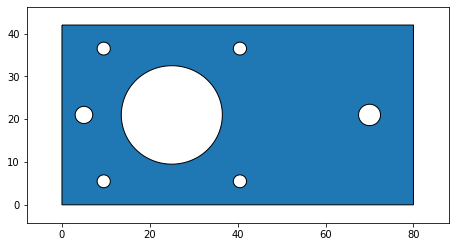

In [36]:
%matplotlib inline

from shapely.geometry import Polygon

def plot_geom( shape, pockets=[], toolr = 1. ):
    from descartes import PolygonPatch

    import matplotlib.pyplot as plt

    cm = 2. / 2.54

    fig, ax = plt.subplots( figsize=( shapes[ 0 ].bounds[ 2 ] * 0.12 * cm, shapes[ 0 ].bounds[ 3 ] * 0.12 * cm ))
    patch = PolygonPatch( shape.buffer( 0 ))
    ax.add_patch( patch )
    
    if len( pockets ) > 0:
        cont = 0;
        for inter in shape.interiors:
            if cont in pockets:
                p = Polygon( inter.coords )
                steps = p.bounds
                
                p = Polygon( p.buffer( 1 ).exterior.coords, [ inter.coords ])
                
                steps = min( steps[ 2 ] - steps[ 0 ], steps[ 3 ] - steps[ 1 ])
                steps = int( steps / ( toolr * 1.9 ))

                for j in range( steps ):
                    np = p.buffer(( toolr * 1.9 ) * float( j + 1. ))
                    
                    for inner in np.interiors:
                        inp = Polygon( inner )
                        patch_p = PolygonPatch( inp )
                        ax.add_patch( patch_p )
                        break
            cont += 1
        
    ax.set_xlim( -shapes[ 0 ].bounds[ 2 ] * 0.1, shapes[ 0 ].bounds[ 2 ] * 1.1 )
    ax.set_ylim( -shapes[ 0 ].bounds[ 3 ] * 0.1, shapes[ 0 ].bounds[ 3 ] * 1.1 )
    plt.show()
    
plot_geom( shapes[ 0 ])


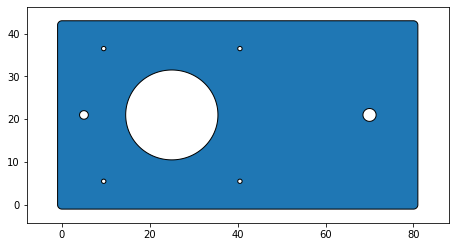

In [37]:
%matplotlib inline

plot_geom( shapes[ 0 ].buffer( 1 ))

In [46]:
import re

def XYZ( pos ):
    if len( pos ) < 4:
        return ", ".join([ a + ( "%.2f" % b ) for a,b in list( zip( list( 'XYZ' ), pos ))]) + ";\n"
    else:
        return ", ".join([ a + ( "%.2f" % b ) for a,b in list( zip( list( 'XYZF' ), pos ))]) + ";\n"

    
config = { "offx": 1., "offy": 1., "pos": ( 0., 0., 2.3 ), "zcut": 2., "fhole": 60., "fcut": 90.,
                 "ftrav": 600., "toolr": 1., "zhigh": 2.3 }


def gcode_write_poly( file, poly, desc, zhigh=10., zcut=0., ftrav=600., fhole=60., fcut=90., 
                     offx=0., offy=0., pos=(0,0,0), toolr=1. ): # some config params are ignored
        xs, ys = poly.coords.xy
    
        file.write( ";\n; " + desc + "\n" )
        start = "G0 " + XYZ(( xs[ 0 ] + offx, ys[ 0 ] + offy, zhigh, ftrav ))
        file.write( start )
        file.write( "G1 " + XYZ(( xs[ 0 ] + offx, ys[ 0 ] + offy, zcut, fhole )))

        lim = len( xs ) - 1
        for i in range( 1, lim + 1 ):
            file.write( "G1 " + XYZ(( xs[ i ] + offx, ys[ i ] + offy, zcut, fcut )))
    
        file.write( "G0 " + XYZ(( xs[ lim ] + offx, ys[ lim ] + offy, zhigh, ftrav )))

        return start
    
                                   
def gen_gcode( gcode, fname, offx=0, offy=0, pos=( 0., 0., 10. ),
                 zcut=0., zhigh=10., fhole=60., fcut=90.,
                 ftrav=600., pockets=[], toolr=1.):
    global config

    gcfile = open( fname, "w+" )
    gcfile.write( ";gcode quadro motor z\n;\n" )
    gcfile.write( "G90;  absolute coords\n" )
    gcfile.write( "G21;  milimeters;\n" )
    gcfile.write( "G92 " + XYZ( pos ) + "\n" )

    start = "G0 " + XYZ(( pos[ 0 ], pos[ 0 ], zhigh, ftrav ))
    gcfile.write( start )
    
    cont = 0
    for inter in gcode.interiors:
        gcode_write_poly( gcfile, inter, "interior " + str( cont ), **config )
        
        if len( pockets ) > 0:
            if cont in pockets:
                p = Polygon( inter.coords )
                steps = p.bounds

                p = Polygon( p.buffer( 1 ).exterior.coords, [ inter.coords ])

                steps = min( steps[ 2 ] - steps[ 0 ], steps[ 3 ] - steps[ 1 ])
                steps = int( steps / ( toolr * 1.9 ))

                for j in range( steps ):
                    np = p.buffer(( toolr * 1.9 ) * float( j + 1. ))

                    for inner in np.interiors:
                        inp = Polygon( inner )
                        gcode_write_poly( gcfile, inp.exterior, "pocket " + str( cont ) + "-" + str( j ), **config )
                        break
            cont += 1
            
    # o exterior é cortado por ultimo pq pode provocar a separação da peça do substrato
    gcode_write_poly( gcfile, gcode.exterior, "exterior", **config )

    gcfile.write( start )
    gcfile.write( "M02" );
    gcfile.close()
   
gen_gcode( shapes[ 0 ].buffer( 1 ), "quadro_motor.gcode", **config )


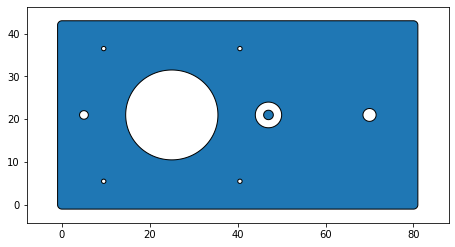

In [47]:
%matplotlib inline

shapes = parse_svg( 'quadro_z_motor_2.svg' )

toolpath = shapes[ 0 ].buffer( 1 )
plot_geom( toolpath, pockets=[ 1 ])

In [48]:
gen_gcode( toolpath, "quadro_motor_p.gcode", pockets=[ 1 ], **config )

In [1]:
from solid import *
from solid.objects import *
import math


def gcode_to_scad( gcfname, zsurf=2., toolr = 1., fcut=90., ftravel=600. ):
    gcfile = open( gcfname, "r" )
    
    # inicia o arquivo do openscad com um objeto nulo
    obj = cube( 0 ); 
    
    pos = [ 0, 0, 0 ]
    xyz = "xyz"
    draw = []
    travel = "green"
    cut = "blue"
    cont = 0
    d = 0
    
    for line in gcfile:
        code = line.strip().lower() 
        if "g0" in code or "g1" in code:
            tokens = code.split(" ")
            
            for token in tokens:
                for i in range( 3 ):
                    if xyz[ i ] in token:
                        pos[ i ] = float( token.replace( xyz[ i ], "" ).replace( ",", "" ))
                       
            if "g0" in code:
                draw.append({ "cmd": "travel", "pos": pos.copy() })
            else:
                draw.append({ "cmd": "cut", "pos": pos.copy() })
            
        cor = cut
                         
        # qdo temos 2 pontos... 
        if len( draw ) == 2:
            # se temos dois pontos de corte ou de viagem:
            if draw[ 0 ][ "cmd" ] == draw[ 1 ][ "cmd" ]:
                if draw[ 0 ][ "cmd" ] == "cut": cor = cut
                if draw[ 0 ][ "cmd" ] == "travel": cor = travel
                         
                # desenha os dois cilindros representando a posicao da ferramenta,
                # o faz o hull entre eles
                obj += color( c=cor )( hull()( 
                        translate( draw[ 0 ][ "pos" ])( 
                            cylinder( r=toolr, h=0.1 )),
                        translate( draw[ 1 ][ "pos" ])( 
                            cylinder( r=toolr, h=0.1 ))))

                ld = ( draw[ 1 ][ "pos" ][ 0 ] - draw[ 0 ][ "pos" ][ 0 ]) ** 2 
                ld += ( draw[ 1 ][ "pos" ][ 1 ] - draw[ 0 ][ "pos" ][ 1 ]) ** 2 
                ld = math.sqrt( ld ) / ( fcut if draw[ 0 ][ "cmd" ] == "cut" else ftravel )
                d += ld
                
            draw.pop( 0 )
                         
            # se estamos deslocando a ferramenta da altura de viagem
            # para a de corte ou vice versa, desenhamos 2 cilindros
            # para representar o volume de corte
            #if draw[ 0 ][ "cmd" ] != draw[ 1 ][ "cmd" ]: 
            #    obj += cylinder( r=toolr, h=plate_h + 2 )

        cont += 1
        #if cont == 562: break

    print( "tempo aprox (m): " + str( d ))
    return obj
                         
                         
scadtoolp = gcode_to_scad( "quadro_motor_p.gcode", zsurf=2.1 )

#strToolp = scad_render( scadtoolp )
#print( strToolp )

tempo aprox: 4.626133988740333


In [ ]:
import viewscad
scad = viewscad.Renderer()
scad.render( scadtoolp, dollar_sign_vars={ "fn": 10 })